In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from sklearn import linear_model
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from scipy.stats.stats import pearsonr, spearmanr, kendalltau 
from scipy import stats

from robustDA import process_cmip6, processing, anchor_regression, plots

%reload_ext autoreload
%autoreload 2

%matplotlib inline

In [8]:
params_climate = {
        "temporalRes": "ann",
        "variables": ["tas"],
        "scenarios": ["historical", "piControl"],
        "startDate": 1950,
        "endDate": 2014,
        "target": "aerosols",
        "anchor": "co2",
    }

params_anchor = {
        "gamma": 5000,
        "h_anchors": ["square"],
    }

In [9]:
modelsDataList, modelsInfoFrame = process_cmip6.read_files_cmip6(params_climate)

modelsInfoFrame.head()

,filename,var,temporalRes,modelFull,model,scenario,spatialRes
0,tas_ann_ACCESS-CM2_historical_r1i1p1f1_g025.nc,tas,ann,ACCESS-CM2,ACC,historical,g025
1,tas_ann_ACCESS-CM2_piControl_r1i1p1f1_g025.nc,tas,ann,ACCESS-CM2,ACC,piControl,g025
2,tas_ann_ACCESS-ESM1-5_historical_r1i1p1f1_g025.nc,tas,ann,ACCESS-ESM1-5,ACC,historical,g025
3,tas_ann_ACCESS-ESM1-5_piControl_r1i1p1f1_g025.nc,tas,ann,ACCESS-ESM1-5,ACC,piControl,g025
4,tas_ann_AWI-CM-1-1-MR_historical_r1i1p1f1_g025.nc,tas,ann,AWI-CM-1-1-MR,AWI,historical,g025


In [10]:
dict_models = processing.split_train_test(modelsDataList, modelsInfoFrame, 
                                          params_climate["target"], params_climate["anchor"])

print(dict_models['trainModels'])
print(dict_models['testModels'])

['AWI' 'BCC' 'CAM' 'CAS' 'CES' 'CIE' 'CMC' 'Can' 'FIO' 'GFD' 'IIT' 'MIR'
 'MPI' 'SAM']
['ACC' 'E3S' 'EC-' 'FGO' 'GIS' 'INM' 'IPS' 'KIO' 'MCM' 'MRI' 'NES' 'Nor'
 'Tai']


In [11]:
gamma = params_anchor["gamma"]
h_anchors = params_anchor["h_anchors"]
target = params_climate["target"]
anchor = params_climate["anchor"]

X_train = dict_models["X_train"]
y_train = dict_models["y_train"]
y_anchor_train = dict_models["y_anchor_train"]

X_test = dict_models["X_test"]
y_test = dict_models["y_test"]
y_anchor_test = dict_models["y_anchor_test"]

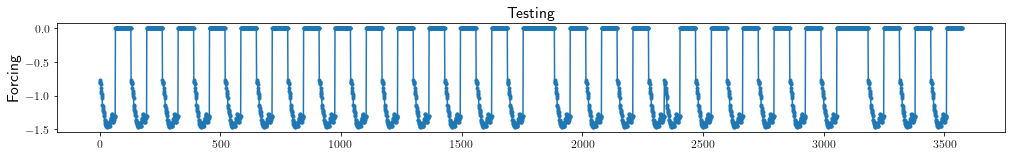

In [12]:
fig = plt.figure(figsize = (17,2))
plt.plot(y_test.values, '.-')
plt.ylabel("Forcing")
plt.title("Testing");

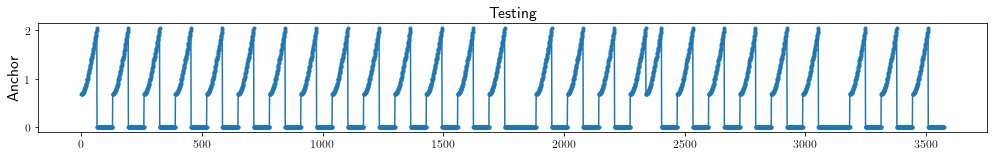

In [13]:
fig = plt.figure(figsize = (17,2))
plt.plot(y_anchor_test.values, '.-')
plt.ylabel("Anchor")
plt.title("Testing");

### Param optimization

In [5]:
import pickle
filename = ("./../output/data/param_optimization_target_" + params_climate["target"]
            + "_" + "anchor_" + params_climate["anchor"] + "_" + "-".join(params_climate["variables"])
            + "_" + "-".join(params_climate["scenarios"]) + "_" + str(params_climate["startDate"])
            + "_" + str(params_climate["endDate"]) + "_"  
            + "nonlinear-h_" + str(len(params_anchor["h_anchors"])) + "-".join(params_anchor["h_anchors"]) + ".pkl")
with open(filename, 'rb') as f:
    mse_gamma, corr_gamma, mi_gamma, gamma_vals, h_anchors, cv_vals, dict_models = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: './../output/data/param_optimization_target_aerosols_anchor_co2_tas_historical-piControl_1850_2014_nonlinear-h_1square.pkl'

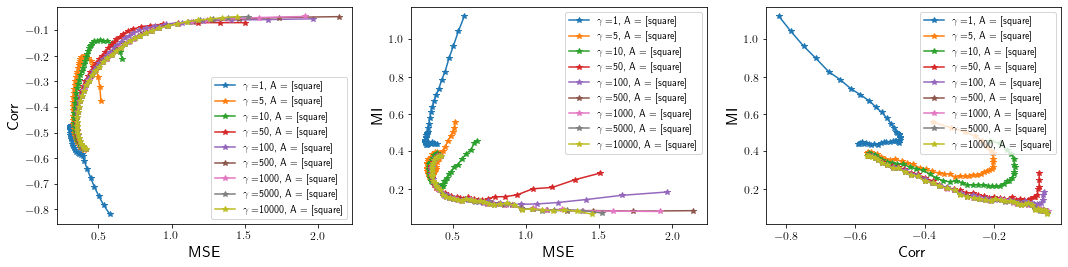

In [170]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))

k=40
mse_gamma = mse_gamma[:,0:1,:k]
corr_gamma = corr_gamma[:,0:1,:k]
mi_gamma = mi_gamma[:,0:1,:k]
for i in range(mse_gamma.shape[0]):
    for j in range(mse_gamma.shape[1]):
        ax1.plot(mse_gamma[i,j,:], corr_gamma[i,j,:], ".-", marker = "*", 
                 label = "$\gamma = $" + str(gamma_vals[i]) + ", A = [" + "-".join(h_anchors) + "]")
#     for j in range(mse_gamma.shape[1]):
#         plt.text(mse_gamma[i,j], corr_gamma[i,j], "$\lambda = $" + str(lambdaCV[j]))
# ax1.set_xscale('log')
ax1.set_xlabel('MSE')
ax1.set_ylabel('Corr')        
ax1.legend();

for i in range(mse_gamma.shape[0]):
    for j in range(mse_gamma.shape[1]):
        ax2.plot(mse_gamma[i,j,:], mi_gamma[i,j,:], ".-", marker = "*", 
                 label = "$\gamma = $" + str(gamma_vals[i]) + ", A = [" + "-".join(h_anchors) + "]")
#     for j in range(mse_gamma.shape[1]):
#         plt.text(mse_gamma[i,j], corr_gamma[i,j], "$\lambda = $" + str(lambdaCV[j]))
# ax2.set_xscale('log')
ax2.set_xlabel('MSE')
ax2.set_ylabel('MI')        
ax2.legend();

for i in range(mse_gamma.shape[0]):
    for j in range(mse_gamma.shape[1]):
        ax3.plot(corr_gamma[i,j,:], mi_gamma[i,j,:], ".-", marker = "*", 
                 label = "$\gamma = $" + str(gamma_vals[i]) + ", A = [" + "-".join(h_anchors) + "]")
#     for j in range(mse_gamma.shape[1]):
#         plt.text(mse_gamma[i,j], corr_gamma[i,j], "$\lambda = $" + str(lambdaCV[j]))
ax3.set_xlabel('Corr')
ax3.set_ylabel('MI')        
ax3.legend();

In [171]:
fig.savefig("./../output/figures/target_aerosols_anchor_co2_pareto_h1_square.pdf", bbox_inches="tight")

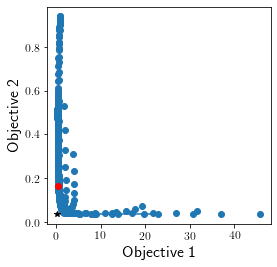

Gamma = 10
h_anchors = 
Lambda = 372.7593720314938


In [14]:
fig = plt.figure(figsize = (4,4))
lambdavals = np.logspace(-2, 6, cv_vals)
gammaSel, hSel, lambdaSel, pf_X, pf_Y = anchor_regression.choose_gamma_h_lambda_pareto(mse_gamma, corr_gamma, 
                                             gamma_vals, h_anchors, lambdavals, maxX=False, maxY=False)
print("Gamma = " + str(gammaSel)) 
print("h_anchors = " + "-".join(hSel))
print("Lambda = " + str(lambdaSel))

In [15]:
hSel = ["square"]
anchor_regression.anchor_regression(dict_models, gammaSel, hSel, lambdaSel, params_climate)

### Cross validation

In [129]:
lambdaSel, mse_df, corr_pearson, mi, lambdasCV = anchor_regression.cross_validation_anchor_regression(
    modelsDataList,
    modelsInfoFrame,
    dict_models,
    params_climate,
    gamma,
    h_anchors,
    30,
    sel_method="MSE",
    display_CV_plot=False,
)

In [130]:
mse_test = np.zeros([len(lambdasCV), 1])
corr_pearson_test = np.zeros([len(lambdasCV), 1])
mi_test = np.zeros([len(lambdasCV), 1])

X, y, y_anchor, Xt, yt, yt_anchor, std_X_train = anchor_regression.standardize(dict_models)
X_PA, y_PA = anchor_regression.transformed_anchor_matrices(X, y, y_anchor, gamma, h_anchors)

for i in range(len(lambdasCV)):
    regr = linear_model.Ridge(alpha=X.shape[0] * lambdasCV[i] / 2)
    regr.fit(X_PA, y_PA)
    y_test_pred = regr.predict(Xt)
    residuals = (yt - y_test_pred).reshape(-1)

    mse_test[i] = np.mean((yt - y_test_pred) ** 2)
    corr_pearson_test[i] = np.round(np.corrcoef(np.transpose(yt_anchor), np.transpose(residuals))[0, 1], 2)
    mi_test[i] = np.round(mutual_info_regression(yt_anchor, residuals)[0], 2)

In [131]:
import pickle

""" Save CV values"""

filename = "./../output/data/CV_aer_co2_gamma5000.pkl"
with open(filename, "wb") as f:
    pickle.dump([lambdaSel, mse_df, corr_pearson, mi, lambdasCV, mse_test, corr_pearson_test, mi_test], f)

In [151]:
""" Read CV values"""

filename = "./../output/data/CV_aer_co2_gamma5000_square_noAhstd_2.pkl"
with open(filename, "rb") as f:
    lambdaSelMSE, mse_df, corr_pearson, mi, lambdasCV, mse_test, corr_pearson_test, mi_test = pickle.load(f)

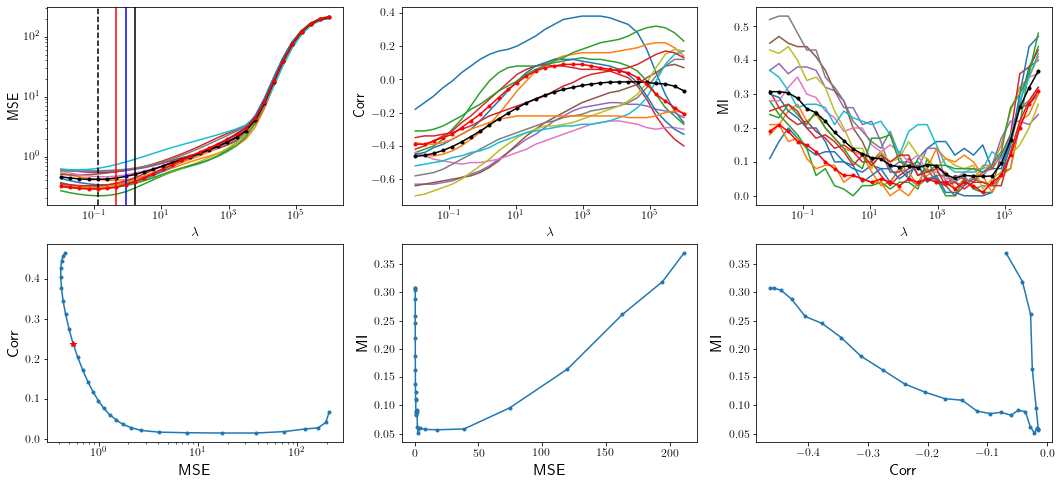

In [152]:
fig, axes = plt.subplots(2, 3, figsize=(18, 8))

nbStd = np.array([1, 2, 3])
clr = ["r", "b", "k"]

for i in range(mse_df.shape[1] - 1):
    axes[0, 0].plot(mse_df.index, mse_df.iloc[:, i], label="_nolegend_")
axes[0, 0].plot(mse_df.index, mse_df.iloc[:, i + 1], "k.-")
axes[0, 0].axvline(lambdaSelMSE[0], ls="--", color="k", label="$\\lambda_{opt}$ = " + str(np.round(lambdaSelMSE[0], 2)))
for j in range(len(lambdaSelMSE) - 1):
    axes[0, 0].axvline(lambdaSelMSE[j + 1], color=clr[j], label="$\\lambda_{" + str(nbStd[j])
        + " SEM} $ = " + str(np.round(lambdaSelMSE[j + 1], 2)))
axes[0, 0].set_xscale("log")
axes[0, 0].set_yscale("log")
axes[0, 0].set_xlabel("$\\lambda$", fontsize=14)
axes[0, 0].set_ylabel("MSE", fontsize=14)
axes[0, 0].plot(lambdasCV, mse_test, 'r.-')

for j in range(corr_pearson.shape[1]):
    axes[0, 1].plot(lambdasCV, corr_pearson[:, j], label="_nolegend_")
axes[0, 1].plot(lambdasCV, np.mean(corr_pearson, axis = 1), "k.-")
axes[0, 1].set_xscale("log")
# axes[0, 1].set_yscale("log")
axes[0, 1].set_xlabel("$\\lambda$", fontsize=14)
axes[0, 1].set_ylabel("Corr", fontsize=14)
axes[0, 1].plot(lambdasCV, corr_pearson_test, 'r.-')
        
for j in range(mi.shape[1]):
    axes[0, 2].plot(lambdasCV, mi[:, j], label="_nolegend_")
axes[0, 2].plot(lambdasCV, np.mean(mi, axis = 1), "k.-")
axes[0, 2].set_xscale("log")
# axes[0, 2].set_yscale("log")
axes[0, 2].set_xlabel("$\\lambda$", fontsize=14)
axes[0, 2].set_ylabel("MI", fontsize=14);
axes[0, 2].plot(lambdasCV, mi_test, 'r.-')

lambdaSelPareto, pf_X, pf_Y, ind = anchor_regression.choose_lambda_pareto(mse_df.iloc[:,-1].values, 
                               np.mean(corr_pearson, axis = 1), lambdasCV, maxX=False, maxY=False, plot_var = False)

axes[1, 0].plot(mse_df.iloc[:, -1], np.abs(np.mean(corr_pearson, axis = 1)), ".-")
axes[1, 0].plot(pf_X[ind], pf_Y[ind], "r*")
axes[1, 0].set_xscale("log")
axes[1, 0].set_xlabel('MSE')
axes[1, 0].set_ylabel('Corr')        

axes[1, 1].plot(mse_df.iloc[:, -1], np.mean(mi, axis = 1), ".-")
axes[1, 1].set_xlabel('MSE')
axes[1, 1].set_ylabel('MI')        

axes[1, 2].plot(np.mean(corr_pearson, axis = 1), np.mean(mi, axis = 1), ".-")
axes[1, 2].set_xlabel('Corr')
axes[1, 2].set_ylabel('MI');

In [153]:
lambdaSelMSE

array([0.1268961 , 0.45203537, 0.85316785, 1.61026203])

In [154]:
lambdaSelPareto

3.039195382313198

In [137]:
anchor_regression.anchor_regression(dict_models, gamma, h_anchors, lambdaSelPareto, params_climate)

### Subagging

In [ ]:
import pickle
filename = ("./../output/data/subagging_aerosols_co2_gamma_5000_square_Ahstd.pkl")
with open(filename, 'rb') as f:
    mse_gamma, corr_gamma, mi_gamma, gamma_vals, h_anchors, cv_vals, dict_models = pickle.load(f)